# Dinkey Creek

#### Dan Krofcheck
Krofcheck@Gmail.com 
 
#### Project description -- working with the Dinkey Creek watershed landscape, initially paramterized by Shuang. Ecoregion creation and model paramterization (including the addition of two shrub species and a shrub functional type) are described in this notebook, as well as the creation of a set of functions to aid in the Century succession extension calibration / paramterization (given the move to Century v4.0 in Landis-II). Ultimately this notebook will be split into a description of project specific work, and a collection of Landis-II tools which will be used in subsequent modeling studies.


In [56]:
# Specify inline plots for notebook
%matplotlib inline

# Libraries -- overkill for the time being
import matplotlib.pyplot as plt
from lxml import etree
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain

# Set working dir
wrkDir = 'C:/Research/Dinkey_Creek/GIS_Data_And_Maps/'


### Ecoregion Creation
#### The Dinkey Creek landsacpe is characterized by an elevation gradient, increasing along a southwest to northeast transect over ~300 - 3000 meters (Fig 1). Initially, we split the landscape into five elevation bins, which roughly corresponded with broad patterns in precipitation and temperature trends across the watershed. 

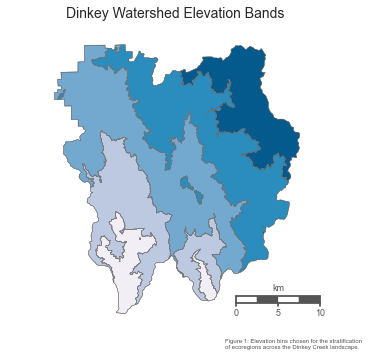

In [75]:
shp = fiona.open(wrkDir + 'DinkeyElevationShp.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyElevationShp', 'Elevation',
    color='grey',
    zorder=2)

# set up a map dataframe
elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Elevation_info[shape[0]].keys(),m.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey Watershed Elevation Bands', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure 1: Elevation bins chosen for the stratification
of ecoregions across the Dinkey Creek landscape.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()

#### We used GSSURGO data to bin the landscape by soil parent material (Figure 2), which roughly tracked soil and clay content, and consequently water holding capacity. We then generated ecoregions given the stratification of elevation and soil groups (Figure 3), such that within each ecoregion, soil and climate characteristics are reasonably homogeneous. Nine distinct parent material groups were lumped into three related bins to simplify the landscape (Table 1). 

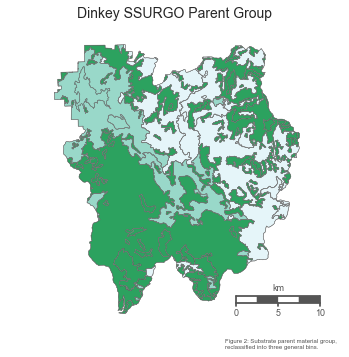

Table 1: The attribute table for the GSSURGO vector data that we used to define coregions
described nine distinct groups. In an effort to represent the edaphic gradient acros the Dinkey
Watershed, we binned these parent material groups into three categories (Figure 2)


In [73]:
shp = fiona.open(wrkDir + 'DinkeyGSSURGODissolveNAD83.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig2 = plt.figure(figsize = (6,6))
ax = fig2.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyGSSURGODissolveNAD83', 'PGroup',
    color='grey',
    zorder=2)

# set up a map dataframe
parentgroup = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.PGroup]})
for shape in enumerate(df_map['poly']):
    keys, values = m.PGroup_info[shape[0]].keys(),m.PGroup_info[shape[0]].values()
    parentgroup.append(values[3])
df_map['ParentGroup'] = parentgroup
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
ParentGFC = ['#e5f5f9','#99d8c9','#2ca25f']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.ParentGroup):
    ax.add_collection(PatchCollection(df_map.patches[df_map.ParentGroup == feature], facecolor= ParentGFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey SSURGO Parent Group', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure 2: Substrate parent material group,
reclassified into three general bins.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()

# Display a table of the GSSURGO parent material binning for transparency
gssurgo_bins = pd.read_csv(wrkDir + 'GSSURGO_Dissolve.txt', sep = ',')
gssurgo_bins
print '''Table 1: The attribute table for the GSSURGO vector data that we used to define coregions
described nine distinct groups. In an effort to represent the edaphic gradient acros the Dinkey
Watershed, we binned these parent material groups into three categories (Figure 2)'''

#### We overlayed the three substrate bins and five elevation bands to generate the eight Landis-II ecoregions (Figure 3)

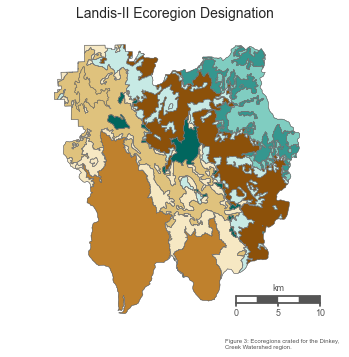

In [80]:
shp = fiona.open(wrkDir + 'EcoregionsNAD83.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig3 = plt.figure(figsize = (6,6))
ax = fig3.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'EcoregionsNAD83', 'Ecoregion',
    color='grey',
    zorder=2)

# set up a map dataframe
ecoregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Ecoregion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Ecoregion_info[shape[0]].keys(),m.Ecoregion_info[shape[0]].values()
    ecoregion.append(values[5])
df_map['Ecoregion'] = ecoregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
               '#c7eae5', '#80cdc1','#35978f', '#01665e']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.Ecoregion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Ecoregion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1
ax.set_title('Landis-II Ecoregion Designation', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure 3: Ecoregions crated for the Dinkey,
Creek Watershed region.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()